## To do
- Fazer avaliação de modelo.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.datasets import load_iris

# Classificação

### Naive Bayes

- O **Gaussino** assume que a distribuição P(Xi|Ck) é uma **normal** com parâmetros mi e desvio padrão estimados via máxima verossimilhança, ou seja, **dados contínuos**.
- O **Bernoulli** assume que os dados sejam **binários**.
- O **Multinomial** assume que os dados sejam **discretos** porém não necessariamente binários, com **relação de ordem**, por exemplo, contagem de palavras.

OBS.: Cada P(Xi|Ck) é uma distribuição, sejam ela gaussiana, bernoulli ou multinomial.

In [5]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [6]:
data = load_iris(return_X_y=True)
df = pd.DataFrame(data[0], columns=['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width'])
df['target'] = data[1]

In [7]:
df.sample(5)

,Sepal Length,Sepal Width,Petal Length,Petal Width,target
12,4.8,3.0,1.4,0.1,0
126,6.2,2.8,4.8,1.8,2
75,6.6,3.0,4.4,1.4,1
138,6.0,3.0,4.8,1.8,2
22,4.6,3.6,1.0,0.2,0


In [8]:
X = df.iloc[:,:4]
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = GaussianNB()
model.fit(X_train,y_train)

result = pd.DataFrame(y_test)
result['predict_naive'] = list(model.predict(X_test))

result.sample(5)

,target,predict_naive
109,2,2
29,0,0
15,0,0
51,1,1
118,2,2


In [9]:
#Definindo probabilidade à priori das classes.
model2 = GaussianNB(priors=[0.2,0.2,0.6])
model2.fit(X_train,y_train)

GaussianNB(priors=[0.2, 0.2, 0.6])

In [10]:
proba = model.predict_proba(X_test)
log_proba = model.predict_log_proba(X_test)

#Nota: A probabilidade do naive bayes não é muito boa, pois usa a hipótese de independência, 
#o que importa é qual possui a maior probabilidade.

Para o **MultinomialNB**, o parâmetro **fit_prior** (default True), especifica se as classes vão possuir probabilidades de acordo com o **dataset** ou uma **distribuição uninforme**.

Para o **BernoulliNB**, o parâmetro **fit_prior** também vale. **Binarize** é o **threshold** para um valor virar True ou continuar False. Por padrão é 0.0, ou seja, 0 é false 1 é true.

Para os dois, **Alpha**, é o parâmetro de suavização de laplace, default 1.0, 0.0 é sem. [VER FÓRMULA DEPOIS]

### Regressão Logística

**Parâmetros:** 

- **penalty** = 'l1' ou 'l2';
- **C** = float, inverso da regularização, pequenos valores são regularizações maiores;
- **fit_intercept** and **intercept_scaling**, define se vai ter bias e quanto é o valor. Default é True e 1.0;
- **class_weight**, dict (pesos customizados) ou balanced (peso proporcional ao dataset) ou None (todos iguais);
- **solver** = VER COM O LUCAS | {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’};

In [11]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [12]:
log_reg = LogisticRegression(penalty='l2', C=1.0)
log_reg.fit(X_train, y_train)

result['log_reg'] = list(log_reg.predict(X_test))
result.sample(5)

,target,predict_naive,log_reg
68,1,1,1
133,2,1,2
73,1,1,1
18,0,0,0
143,2,2,2


In [13]:
#Peso de cada feature depois de fittado. Tem 3 pois como é um problema multiclasse, é fittado um log reg binário para cada
#classe, é 1 ou não, é 2 ou não. 

log_reg.coef_

array([[ 0.37837225,  1.3362905 , -2.08244463, -0.93126854],
       [ 0.34937592, -1.44126614,  0.48555836, -1.08172903],
       [-1.45856852, -1.43890209,  2.19420366,  2.10495849]])

In [14]:
#Com elastic net

el = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.5, tol=0.0001)
el.fit(X_train, y_train)

result['log_reg_el'] = list(el.predict(X_test))
result.sample(5)

,target,predict_naive,log_reg,log_reg_el
29,0,0,0,0
30,0,0,0,0
127,2,2,2,2
142,2,2,2,2
108,2,2,2,2


### Knn

- **algorithm:** auto acha o melhor. Pode ser ball_tree, kd_tree ou brute. 
- **leaf_size:** VER DPS.
- **p:** power da distância de Minkowski.
- **metrics:** podem ser outras, ver documentação da DistanceMetrics.

In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [16]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='kd_tree', leaf_size=30, p=2, metric='minkowski')

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [17]:
#Retorna os k vizinhos e a distância.
knn.kneighbors([[1,1,1,1]])

(array([[3.81051178, 3.96358424, 3.99624824, 4.03608721, 4.27317212]]),
 array([[71, 47, 46, 52, 50]], dtype=int64))

In [18]:
result['knn'] = list(knn.predict(X_test))
result.sample(5)

,target,predict_naive,log_reg,log_reg_el,knn
128,2,2,2,2,2
22,0,0,0,0,0
82,1,1,1,2,1
30,0,0,0,0,0
75,1,1,1,2,1


### SVM

- **C:** 1/alpha, ou seja, quanto menor que 1, permite um svm mais relaxado. É o peso da missclassification na cost func.
- **kernel:** ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’ ou ‘precomputed’.
- **degree:** grau do polinomial.
- **gamma:** 1/n_features é o padrão do parâmetro do kernel.
- **probability:** True para retornar as probabilidades.

In [19]:
from sklearn.svm import SVC

In [20]:
svm = SVC(C=1.0, kernel='rbf', gamma=0.25, probability=True)

svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.25, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
result['svm'] = list(svm.predict(X_test))
result.sample(5)

,target,predict_naive,log_reg,log_reg_el,knn,svm
26,0,0,0,0,0,0
108,2,2,2,2,2,2
51,1,1,1,2,1,1
56,1,2,1,2,1,1
29,0,0,0,0,0,0


In [22]:
#Distância ao plano separadore.
svm.decision_function([[1,1,1,1]])

array([[-0.35238517,  0.85238517,  2.5       ]])

### Decision Tree

- **criterion:** 'gini' ou 'entropy'.
- **splitter:** 'best' ou 'random' para o melhor de um sample de tamanho 'max_features' random.
- **max_depth:** int que diz a profundidade máxima da árvore. Se None, vai até os nós serem puros ou terem menos de min_samples_split elementos.
- **min_samples_split:** número mínimo para splitar um nó (critério de parada do max_depth).
- **min_samples_leaf:** número mínimo para um nó poder ser uma folha. Dúvidas: https://stackoverflow.com/questions/46480457/difference-between-min-samples-split-and-min-samples-leaf-in-sklearn-decisiontre
- **min_weight_fraction_leaf:** porcentagem de peso (com relação ao peso total do input) para poder ser uma folha.
- **max_features:** número máximo de features a serem olhadas'.
- **max_leaf_nodes:** número máximo de folhas.
- **min_impurity_decrease:** Só splita um nó se a impureza descresceu este valor.
- **min_impurity_split:** threshold para splitar um nó, ou seja, se a impureza for menor qu este parâmetro, nem precisas dividir, já ta bom.
- **class_weight:** Dicionário com os pesos de cada classe ou 'balanced', pesos são atribuidos com base na proporção da base. Default é 1 para todas as classes.

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pydotplus

In [24]:
tree_clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=3)

tree_clf.fit(X_train, y_train, sample_weight=[1 for x in X_train.iterrows()])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [25]:
result['tree'] = list(tree_clf.predict(X_test))
result.sample(5)

,target,predict_naive,log_reg,log_reg_el,knn,svm,tree
42,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0
143,2,2,2,2,2,2,2


In [26]:
tree_clf.feature_importances_

array([0.0174022 , 0.04560307, 0.63319904, 0.30379569])

In [27]:
tree.export_graphviz(tree_clf, out_file='tree.dot', feature_names=list(df.columns)[:4], 
                     class_names=['Setosa','Versicolour', 'Virginica'], filled=True, leaves_parallel=True, rounded=True) 
#acessar: http://www.webgraphviz.com/ e colar o que tem em tree.dot

### Random Forest - A CONFIRMAR

In [28]:
#http://scikit-learn.org/stable/modules/ensemble.html
from sklearn.ensemble import RandomForestClassifier

### Bagging - A CONFIRMAR

In [29]:
from sklearn.ensemble import BaggingClassifier

### Boosting - A CONFIRMAR

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

# Regressão

In [31]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [32]:
Xl = df.iloc[:,:3]
yl = df['Petal Width']
Xl_train, Xl_test, yl_train, yl_test = train_test_split(Xl, yl, test_size=0.33, random_state=42)

In [33]:
result_l = pd.DataFrame(yl_test)

In [34]:
#Sem regularização
lr = LinearRegression(normalize=True, copy_X=True)
lr.fit(Xl_train, yl_train)

result_l['lr_normal'] = list(lr.predict(Xl_test))

lr.coef_

array([-0.26112897,  0.25780067,  0.54432941])

In [35]:
#Com l1
lr2 = Lasso(alpha=0.001, max_iter=1000, normalize=True, copy_X=True)
lr2.fit(Xl_train, yl_train)

result_l['lr_l1'] = list(lr2.predict(Xl_test))

list(lr2.coef_)

[-0.10430252822604663, 0.12660120807021039, 0.46198588646856414]

In [36]:
#Com l2
lr3 = Ridge(alpha=0.001, max_iter=1000, normalize=True, copy_X=True)
lr3.fit(Xl_train, yl_train)

result_l['lr_l2'] = list(lr3.predict(Xl_test))

list(lr3.coef_)

[-0.25322580701377256, 0.2518762072897433, 0.5399905054938664]

In [37]:
#Com elastic_net
lr4 = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=1000, normalize=True, copy_X=True)
lr4.fit(Xl_train, yl_train)

result_l['lr_elastic'] = list(lr4.predict(Xl_test))

list(lr4.coef_)

[0.0, 0.04687718798362693, 0.394871244538662]

In [38]:
result_l.sample(6)

,Petal Width,lr_normal,lr_l1,lr_l2,lr_elastic
131,2.0,2.284243,2.294360,2.284809,2.275173
18,0.3,0.300378,0.352492,0.303951,0.419278
145,2.3,1.738162,1.763859,1.739191,1.763826
27,0.2,0.244737,0.274266,0.247003,0.326241
19,0.3,0.348190,0.322676,0.347888,0.340304
81,1.0,1.080342,1.120083,1.081950,1.143392


### Outros modelos para regressão

In [39]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [40]:
rtree = DecisionTreeRegressor(criterion='mse')
    
rtree.fit(Xl_train, yl_train)

result_l['tree'] = list(rtree.predict(Xl_test))

In [41]:
knnr = KNeighborsRegressor()
    
knnr.fit(Xl_train, yl_train)

result_l['knn_regression'] = list(knnr.predict(Xl_test))

In [42]:
svr = SVR()
    
svr.fit(Xl_train, yl_train)

result_l['svr'] = list(svr.predict(Xl_test))

In [43]:
result_l.sample(6)

,Petal Width,lr_normal,lr_l1,lr_l2,lr_elastic,tree,knn_regression,svr
42,0.2,0.267434,0.227330,0.266022,0.233203,0.2,0.22,0.198813
78,1.5,1.514141,1.500821,1.513268,1.482728,1.4,1.48,1.467420
76,1.4,1.442757,1.543314,1.447497,1.596502,1.8,1.48,1.474583
65,1.4,1.328478,1.406931,1.332386,1.452616,1.3,1.40,1.308588
4,0.2,0.268310,0.261588,0.268836,0.291441,0.3,0.36,0.222959
109,2.5,2.252174,2.203456,2.249695,2.147336,2.2,2.06,2.307354


# Agrupamento

### K-Means

In [46]:
from sklearn.cluster import KMeans

In [51]:
centroid = np.array([[1,1,1,1],[2,2,2,2],[3,3,3,3]])
centroid

array([[1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3]])

In [55]:
#init: clusteres iniciais
#n_init: número de vezes que vai começar um k-means com seed diferente.

km_test = KMeans(n_clusters=3, init=centroid, n_init=1, tol=0.0001)
km = KMeans(n_clusters=3)

km.fit(df.iloc[:,:4])

km.predict(df.iloc[:,:4].sample(10))

array([1, 2, 2, 2, 2, 2, 0, 2, 0, 2])

In [56]:
km.cluster_centers_

array([[6.85      , 3.07368421, 5.74210526, 2.07105263],
       [5.006     , 3.418     , 1.464     , 0.244     ],
       [5.9016129 , 2.7483871 , 4.39354839, 1.43387097]])

### Hieráquico

In [188]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering

**Scipy**

- **Primeiro argumento** é matriz de distância retornada por _pdist_ ou conjunto de observações.
- **method:** single, complete, average ou ward.
- **metric:** para calcular a matriz de distância, caso não seja dada. Ver todas em https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html.
- **Retorna** uma matrix no formato de linkage. Usar _fcluster_ ou _dendrogram_ para ver.

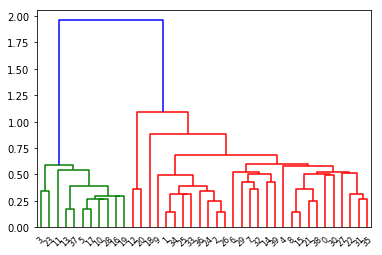

In [204]:
hc = linkage(df.iloc[:,:4].sample(40), method='single', metric='euclidean')
plt.figure()
dendrogram(hc)
plt.show()

In [213]:
fcluster(hc,t=1.25, criterion ='distance')

array([2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2], dtype=int32)

### DBScan

- eps: distância máxima para ser considerado vizinho.
- min_samples: número mínimo ou soma de pesos mínima para um ponto ser considerado core point.
- metric: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html qualquer uma.
- algorithm: 'bal_tree', 'kd_tree', 'brute'.
- p: power of Minkowski.

In [57]:
from sklearn.cluster import DBSCAN

In [96]:
db = DBSCAN(eps=0.3, min_samples=10, metric='euclidean', algorithm='brute')

db.fit_predict(df.iloc[:,:4])[:10]

array([ 0,  0,  0,  0,  0, -1, -1,  0, -1,  0], dtype=int64)

In [97]:
db.core_sample_indices_

array([ 0,  4,  7,  9, 12, 17, 27, 30, 34, 37, 39, 45, 49], dtype=int64)

In [98]:
np.unique(db.labels_)

array([-1,  0], dtype=int64)

### Gaussian Mixture Model

- weights_init: que porra é essa.
- means_init: média dos componentes.
- precisions_init: uma matrix feature x feature para cada componente, sendo o iverso da matrix de covariância.

In [64]:
from sklearn.mixture import GaussianMixture

In [168]:
cov_mat = np.array([[[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],
                    [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],
                    [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]])

In [169]:
gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=100, n_init=1, weights_init=[0.2,0.2,0.6], 
                      means_init=[[1,1,1,1],[2,2,2,2],[3,3,3,3]], precisions_init=cov_mat)

gmm.fit(df.iloc[:,:4])

gmm.predict(df.iloc[:,:4].sample(5))

array([2, 1, 1, 2, 2], dtype=int64)

In [170]:
#Dado um ponto, retorna a probabilidade de pertencer a cada um dos n clusteres.
gmm.predict_proba(df.iloc[:,:4].sample(5))

array([[0.00000000e+000, 1.31807838e-033, 1.00000000e+000],
       [0.00000000e+000, 5.63149713e-109, 1.00000000e+000],
       [6.48837748e-001, 3.51162252e-001, 4.47742661e-011],
       [0.00000000e+000, 2.23658282e-028, 1.00000000e+000],
       [0.00000000e+000, 1.18684562e-106, 1.00000000e+000]])

In [175]:
print(gmm.weights_,'\n\n',gmm.means_,'\n\n',gmm.covariances_,'\n\n',gmm.converged_)

[0.09062    0.24271325 0.66666675] 

 [[4.8967348  3.32444189 1.41159932 0.20010569]
 [5.04679566 3.45293135 1.48356447 0.26038848]
 [6.26199979 2.87199997 4.90599956 1.67599983]] 

 [[[ 0.11561732  0.10786095  0.02208479 -0.00511506]
  [ 0.10786095  0.16795556  0.02345769 -0.01315353]
  [ 0.02208479  0.02345769  0.00634564 -0.00146125]
  [-0.00511506 -0.01315353 -0.00146125  0.0014611 ]]

 [[ 0.11793846  0.08947742  0.01053959  0.01364558]
  [ 0.08947742  0.12820108  0.00445017  0.01819795]
  [ 0.01053959  0.00445017  0.03674387  0.00703503]
  [ 0.01364558  0.01819795  0.00703503  0.01393746]]

 [[ 0.4349573   0.12093604  0.44882868  0.16548827]
  [ 0.12093604  0.10961701  0.1413681   0.07922803]
  [ 0.44882868  0.1413681   0.67476646  0.28584458]
  [ 0.16548827  0.07922803  0.28584458  0.17862522]]] 

 True


## Sampling

### Hold-out

In [221]:
from sklearn.model_selection import train_test_split

In [222]:
X, y = np.arange(10).reshape((5, 2)), list(range(5))
X

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [223]:
y

[0, 1, 2, 3, 4]

In [230]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=10,
                                               shuffle=True, stratify=None)

print(Xtrain, '\n\n', ytrain)

[[0 1]
 [8 9]
 [2 3]] 

 [0, 4, 1]


In [231]:
print(Xtest, '\n\n', ytest)

[[4 5]
 [6 7]] 

 [2, 3]


In [232]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=3, test_size=2, shuffle=False, stratify=None)

print(Xtrain, '\n\n', ytrain)

[[0 1]
 [2 3]
 [4 5]] 

 [0, 1, 2]


In [233]:
print(Xtest, '\n\n', ytest)

[[6 7]
 [8 9]] 

 [3, 4]


### K-fold

- **groups:** lista com o tamanho do X. Especifíca a divisão dos grupos.
- **cv:** pode ser o número de KFolds (no caso de ser classificação ele faz um stratified). Ou ainda, passar o return de um cross-validation generator, como Kfolds.
- **scoring:** pode ser http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter ou multiplos, ('metric1', 'metric2').
- **leave-one-out** é só n_splits=n.

In [272]:
from sklearn.model_selection import cross_validate, KFold, cross_val_score

In [279]:
kfolds = KFold(n_splits=5, shuffle=False, random_state=None)

In [280]:
cross_validate(estimator=knn, X=df.iloc[:,:4], y=df.target, cv=kfolds, scoring='accuracy', return_train_score=True)

{'fit_time': array([0.        , 0.01562595, 0.        , 0.        , 0.01561689]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([1.        , 1.        , 0.83333333, 0.93333333, 0.8       ]),
 'train_score': array([1., 1., 1., 1., 1.])}